# Example

After the NIH/3T3 data from the seqFISH+ paper was downloaded with *data/nih3t3/download.py* and preprocessed with *data/nih3t3/preprocess.py*, it can be loaded here. In the following, 15 NIH/3T3 cells and 60 genes are selected.

In [19]:
import pandas as pd
import torch
from src import fishfactor, utils
import matplotlib.pyplot as plt

In [2]:
data = pd.read_feather('data/nih3t3/preprocessed_data.feather')

experiment = 1
fov = 0
cells = [i for i in range(15)]

protrusion_genes = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Net1', 'Trak2', 'Kif1c', 'Kctd10', 'Dynll2', 'Arhgap11a', 'Gxylt1', 'H6pd', 'Gdf11', 'Dync1li2', 'Palld', 'Ppfia1', 'Naa50', 'Ptgfr', 'Zeb1', 'Arhgap32', 'Scd1']
nucleus_perinucleus_genes = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn', 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1', 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6', 'Col5a2', 'Itgb1', 'Calu', 'Pdia3', 'Cyr61']
cytoplasm_genes = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1', 'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1', 'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']
genes = protrusion_genes + nucleus_perinucleus_genes + cytoplasm_genes

data = data[(data.experiment==experiment) & (data.fov==fov) & (data.cell.isin(cells)) & (data.gene.isin(genes))]

# FISHFactor requires a DataFrame with columns 'x', 'y', 'feature', 'group' as input
data = data[['x', 'y', 'gene', 'cell']].rename(columns={'gene' : 'feature', 'cell' : 'group'})

In [3]:
data

,x,y,feature,group
1962,983.037187,491.439462,Col1a1,0
1963,855.838287,348.029785,Col1a1,0
1964,1013.540425,348.943227,Col1a1,0
1965,888.040550,439.687959,Col1a1,0
1966,893.542336,369.689549,Col1a1,0
...,...,...,...,...
566227,1771.166019,1722.593260,Caprin1,14
566228,1750.411005,1659.885259,Caprin1,14
566229,1884.415763,1815.098347,Caprin1,14
566230,1861.664183,1854.348523,Caprin1,14


In [4]:
device = 'cuda:0'

model = fishfactor.FISHFactor(
    data=data,
    n_latents=3,
    nu=1.5,
    n_inducing=100,
    grid_resolution=50,
    min_density=0.1,
    masks=None,
    normalize_coordinates=True,
    device=device
).to(device=device)

In [5]:
results = model.inference(
    lr=5e-3,
    lrd=0.5**(1 / 2000),
    n_particles=15,
    max_epochs=20000,
    patience=3000,
    delta=0.01,
    save_every=None,
    save_dir=None,
    max_points=10000,
    print_every=500,
)

epoch: 0, loss: -3.2924, min loss: [100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0], patience: 3000
epoch: 500, loss: -2.8119, min loss: [-2.291506767272949, -2.7217156887054443, -2.47774600982666, -4.097797870635986, -1.0825765132904053, -1.9312167167663574, -1.608926773071289, -2.8008782863616943, -1.5669567584991455, -2.0544071197509766, -1.3946290016174316, -3.197871446609497, -1.6043939590454102, -2.746424436569214, -1.3318432569503784], patience: 2998
epoch: 1000, loss: -1.5995, min loss: [-2.324464797973633, -2.77589750289917, -2.5540385246276855, -4.169473171234131, -1.1050571203231812, -1.9641304016113281, -1.6446226835250854, -2.8615379333496094, -1.600571870803833, -2.115222930908203, -1.4171384572982788, -3.2775235176086426, -1.6386603116989136, -2.7898178100585938, -1.3553318977355957], patience: 2998
epoch: 1500, loss: -1.6411, min loss: [-2.407592535018921, -2.8887748718

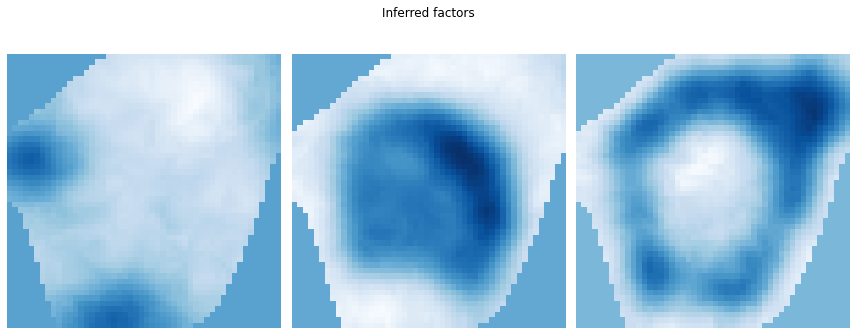

In [30]:
# index between 0 and 14
evaluation_cell = 0

z = utils.gp_percentiles(
    model=model.gp_list[evaluation_cell],
    coords=model.grid,
    percentiles=[0.5],
    n_samples=10,
)[0].detach().cpu()

mask = model.masks[evaluation_cell].cpu()

fig, axs = plt.subplots(1, z.shape[0], figsize=(4 * z.shape[0], 5))
fig.suptitle('Inferred factors')

for i, ax in enumerate(axs.flatten()):
    ax.matshow(z[i].view(model.grid_resolution, model.grid_resolution) * mask, origin='lower', cmap='Blues', vmax=z.max())
    ax.axis('off')

plt.tight_layout()

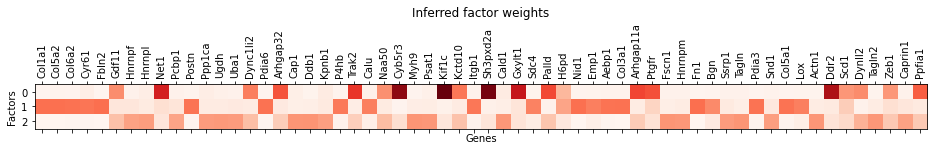

In [28]:
w = results['pyro_params']['w_loc_raw'].detach().cpu().squeeze()
w = torch.nn.Softplus()(w)

plt.matshow(w.T, cmap='Reds')
plt.title('Inferred factor weights')
plt.xlabel('Genes')
plt.xticks(torch.arange(60), labels=data.feature.unique(), rotation='vertical')
plt.ylabel('Factors')
plt.show()